In [1]:
import pandas as pd
from src.features.modified_feature_selector import FeatureSelector
import matplotlib.pylab as plt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np

In [2]:
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
download_har_dataset()

In [3]:
df = load_har_dataset()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


In [4]:
y = load_har_classes()

In [5]:
df["id"] = df.index
df = df.melt(id_vars="id", var_name="time").sort_values(["id", "time"]).reset_index(drop=True)

In [6]:
df.head()

,id,time,value
0,0,0,0.000181
1,0,1,0.010139
2,0,2,0.009276
3,0,3,0.005066
4,0,4,0.010810


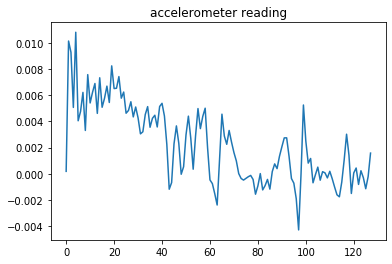

In [7]:
plt.title('accelerometer reading')
plt.plot(df[df["id"] == 0].set_index("time").value)
plt.show()

In [8]:
X = extract_features(df[df["id"] < 500], column_id="id", column_sort="time", impute_function=impute)

Feature Extraction: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


In [9]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-1,value__value_count__value_0,value__value_count__value_1,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,0.001766,0.182234,0.385871,0.369068,0.032822,0.008461,-0.847428,-0.000618,0.000117,0.010256,...,1.0,1.0,-2.848871e-09,-8.289268e-09,-1.655787e-08,0.0,0.0,0.0,0.000009,0.0
1,0.000506,0.167999,-0.008718,-0.004493,0.022767,0.002734,0.044690,0.000018,0.000121,0.004748,...,1.0,1.0,-5.877318e-10,-1.922393e-09,-4.718608e-10,0.0,0.0,0.0,0.000004,0.0
2,0.001106,0.231978,-0.005203,-0.016122,0.026357,0.002620,0.448916,0.000266,0.000160,0.005516,...,1.0,1.0,4.335730e-12,-3.074296e-09,-1.131423e-08,0.0,0.0,0.0,0.000008,0.0
3,0.000932,0.186693,0.040150,0.033541,0.035531,0.005630,-0.621284,-0.000424,0.000161,0.007497,...,1.0,1.0,-1.191508e-10,-3.875581e-09,-1.225939e-08,0.0,0.0,0.0,0.000007,0.0
4,0.000525,0.154255,-0.009908,-0.035693,0.028350,0.001293,0.535210,0.000203,0.000096,0.003863,...,1.0,1.0,8.025438e-11,1.392431e-09,4.529091e-09,0.0,0.0,0.0,0.000004,0.0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y[:500], test_size=.2)

In [11]:
classifier_full = DecisionTreeClassifier()
classifier_full.fit(X_train, y_train)
print(classification_report(y_test, classifier_full.predict(X_test)))

precision    recall  f1-score   support

           1       0.94      0.91      0.92        33
           2       0.80      0.92      0.86        13
           3       1.00      0.92      0.96        12
           4       0.41      0.50      0.45        14
           5       0.41      0.41      0.41        17
           6       0.38      0.27      0.32        11

    accuracy                           0.70       100
   macro avg       0.66      0.66      0.65       100
weighted avg       0.70      0.70      0.70       100



## Multiclass Feature Selection

In [22]:
fs = FeatureSelector(multiclass=True, n_significant=6, multiclass_p_values='all')
fs.fit(X_train,y_train)

FeatureSelector(chunksize=None, fdr_level=0.05, hypotheses_independent=False,
                ml_task='auto', multiclass=True, multiclass_p_values='all',
                n_jobs=4, n_significant=6,
                test_for_binary_target_binary_feature='fisher',
                test_for_binary_target_real_feature='mann',
                test_for_real_target_binary_feature='mann',
                test_for_real_target_real_feature='kendall')

In [23]:
X_train_filt = fs.transform(X_train)
X_test_filt = fs.transform(X_test)

In [27]:
classifier_selected = DecisionTreeClassifier()
classifier_selected.fit(X_train_filt, y_train)
print(classification_report(y_test, classifier_selected.predict(X_test_filt)))

precision    recall  f1-score   support

           1       0.97      0.91      0.94        33
           2       0.75      0.92      0.83        13
           3       1.00      0.92      0.96        12
           4       0.50      0.57      0.53        14
           5       0.60      0.53      0.56        17
           6       0.55      0.55      0.55        11

    accuracy                           0.76       100
   macro avg       0.73      0.73      0.73       100
weighted avg       0.77      0.76      0.76       100



In [31]:
fs.p_values

,p_value_5,p_value_4,p_value_6,p_value_1,p_value_3,p_value_2,p_value
feature,,,,,,,
"value__agg_autocorrelation__f_agg_""var""__maxlag_40",1.640052e-21,1.743183e-11,1.689771e-04,1.141764e-01,1.750315e-22,1.263022e-21,NaN
value__abs_energy,3.124439e-21,1.891009e-14,2.620425e-10,8.632286e-14,6.224058e-35,1.307836e-03,NaN
value__variance,3.302264e-21,1.736042e-14,2.344535e-10,7.504289e-14,6.318314e-35,1.296169e-03,NaN
value__standard_deviation,3.302264e-21,1.736042e-14,2.344535e-10,7.504289e-14,6.318314e-35,1.296169e-03,NaN
"value__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2",5.250213e-21,4.265588e-15,5.040399e-10,2.857850e-22,8.401684e-26,1.831972e-02,NaN
...,...,...,...,...,...,...,...
value__symmetry_looking__r_0.9500000000000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
value__value_count__value_-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
value__value_count__value_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
table_const = fs.p_values[['p_value']]
table_const.index = fs.p_values.index
table_const['relevant'] = False

In [58]:
table_const.head()

,p_value,relevant
feature,,
"value__agg_autocorrelation__f_agg_""var""__maxlag_40",NaN,False
value__abs_energy,NaN,False
value__variance,NaN,False
value__standard_deviation,NaN,False
"value__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2",NaN,False


In [60]:
relevance_table = fs.p_values

In [69]:
# table_const[relevance_table.columns]
p_cols = list(relevance_table.columns.str.startswith('p_value_'))
rel_cols = list(relevance_table.columns.str.startswith('relevant_'))
p = [np.NaN for x in range(len(rel_cols))]
rel = [False for x in range(len(p_cols))]
d = dict(zip(cols,vals))

,p_value,relevant,p_value_5,p_value_4,p_value_6,p_value_1,p_value_3,p_value_2
feature,,,,,,,,
"value__agg_autocorrelation__f_agg_""var""__maxlag_40",NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
value__abs_energy,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
value__variance,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
value__standard_deviation,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
"value__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2",NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
value__symmetry_looking__r_0.9500000000000001,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
value__value_count__value_-1,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
value__value_count__value_0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
